# Imputation with trained STIMP in the Pearl River Estuary 

In [1]:
import torch
import numpy as np 
import sys
import os
from dataset.dataset_imputation import PRE8dDataset

In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

## Fig 3b: Missing rate is equal to 0.1

In [5]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.1.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [7]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 14:43:54.149 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 45: 0.0014910557074472308, 8.841627277433872e-06
2025-05-11 14:43:54.394 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 161: 0.0020145191811025143, 9.89530235528946e-06
2025-05-11 14:43:54.670 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 180: 0.0018620046321302652, 9.817071259021759e-06
2025-05-11 14:43:54.934 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 177: 0.002274477621540427, 9.705079719424248e-06
2025-05-11 14:43:55.162 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 152: 0.002120467135682702, 9.96631570160389e-06
2025-05-11 14:43:55.324 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 106: 0.004458919167518616, 9.90321859717369e-06
2025-05-11 14:43:55.610 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Erro

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

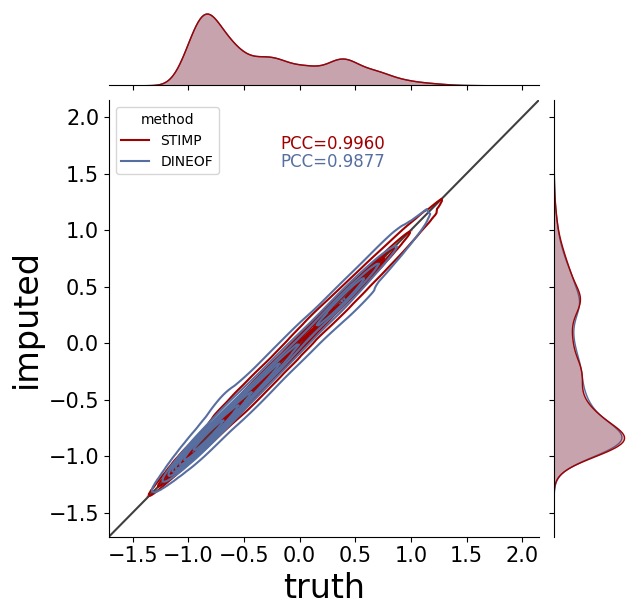

In [8]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.ylim(ypoints)
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 3b: Missing rate is equal to 0.3

In [52]:
config.missing_ratio=0.3
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.3.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [53]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 15:05:50.678 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 44: 0.005508442874997854, 8.286908268928528e-06
2025-05-11 15:05:50.924 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 162: 0.001973017817363143, 9.736744686961174e-06
2025-05-11 15:05:51.152 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 148: 0.002047701505944133, 9.890878573060036e-06
2025-05-11 15:05:51.398 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 163: 0.0021193658467382193, 9.947223588824272e-06
2025-05-11 15:05:51.625 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 151: 0.001720884582027793, 9.93930734694004e-06
2025-05-11 15:05:51.884 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 173: 0.002218881156295538, 9.912531822919846e-06
2025-05-11 15:05:52.104 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Erro

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

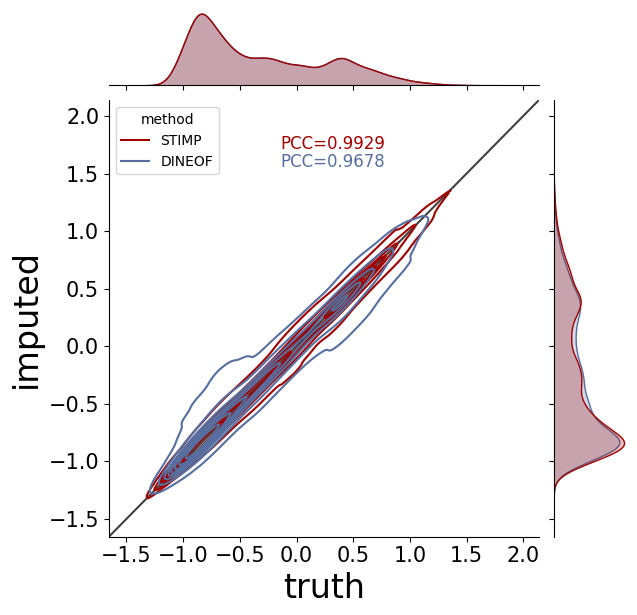

In [54]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.ylim(ypoints)
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 3b: Missing rate is equal to 0.5

In [12]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [15]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 14:47:29.862 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 67: 0.0019250796176493168, 7.151509635150433e-06
2025-05-11 14:47:30.102 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 147: 0.0013824701309204102, 9.963405318558216e-06
2025-05-11 14:47:30.326 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 145: 0.0017284167697653174, 9.819050319492817e-06
2025-05-11 14:47:30.512 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 120: 0.001543168444186449, 9.693088941276073e-06
2025-05-11 14:47:30.719 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 134: 0.0016107747796922922, 9.767943993210793e-06
2025-05-11 14:47:30.946 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 148: 0.0017730435356497765, 9.90892294794321e-06
2025-05-11 14:47:31.175 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative 

PearsonRResult(statistic=0.9868376743082833, pvalue=0.0)
PearsonRResult(statistic=0.9018553339227753, pvalue=0.0)


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

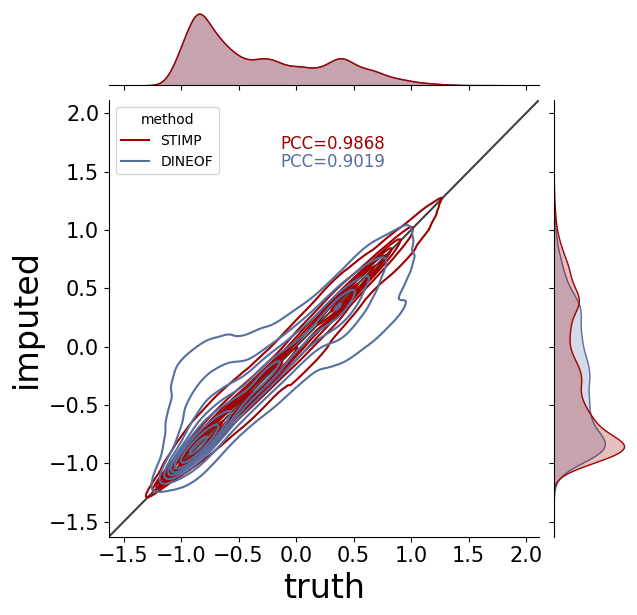

In [16]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.ylim(ypoints)
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:], imputed_our))
print(stat.pearsonr(truth[:], imputed_dineof))
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 3b: Missing rate is equal to 0.7

In [17]:
config.missing_ratio=0.7
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)
model = torch.load("./log/imputation/PRE/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [18]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 14:49:25.657 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 24: 0.0032221016008406878, 4.917383193969727e-07
2025-05-11 14:49:25.832 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 114: 0.0009344807476736605, 9.96061135083437e-06
2025-05-11 14:49:26.020 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 121: 0.0013941103825345635, 9.853276424109936e-06
2025-05-11 14:49:26.229 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 136: 0.0011940064141526818, 9.989133104681969e-06
2025-05-11 14:49:26.428 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 130: 0.0011690087849274278, 9.83069185167551e-06
2025-05-11 14:49:26.635 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 133: 0.0011790381977334619, 9.811134077608585e-06
2025-05-11 14:49:26.837 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative 

PearsonRResult(statistic=0.9551173753689999, pvalue=0.0)
PearsonRResult(statistic=0.7227783409335321, pvalue=0.0)


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

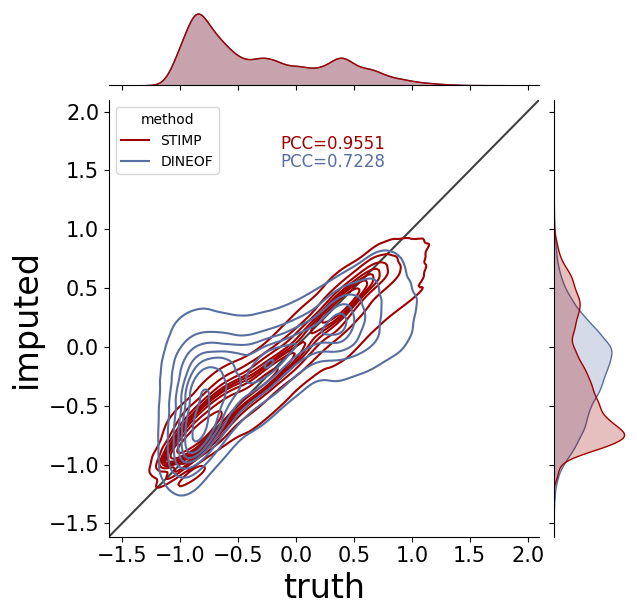

In [19]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.ylim(ypoints)
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:], imputed_our))
print(stat.pearsonr(truth[:], imputed_dineof))
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 3b: Missing rate is equal to 0.9

In [20]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)
model = torch.load("./log/imputation/PRE/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [23]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 14:54:32.351 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 65: 0.000706246355548501, 7.287424523383379e-06
2025-05-11 14:54:32.433 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 53: 0.0002873373159673065, 9.953597327694297e-06
2025-05-11 14:54:32.530 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 62: 0.0001635895314393565, 9.94822767097503e-06
2025-05-11 14:54:32.636 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 68: 0.00018984131747856736, 9.668496204540133e-06
2025-05-11 14:54:32.725 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 57: 0.00013677547394763678, 9.794297511689365e-06
2025-05-11 14:54:32.839 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 74: 0.00017466300050728023, 9.6262083388865e-06
2025-05-11 14:54:32.933 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Erro

PearsonRResult(statistic=0.9462578040774265, pvalue=0.0)
PearsonRResult(statistic=0.3536718379145061, pvalue=0.0)


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

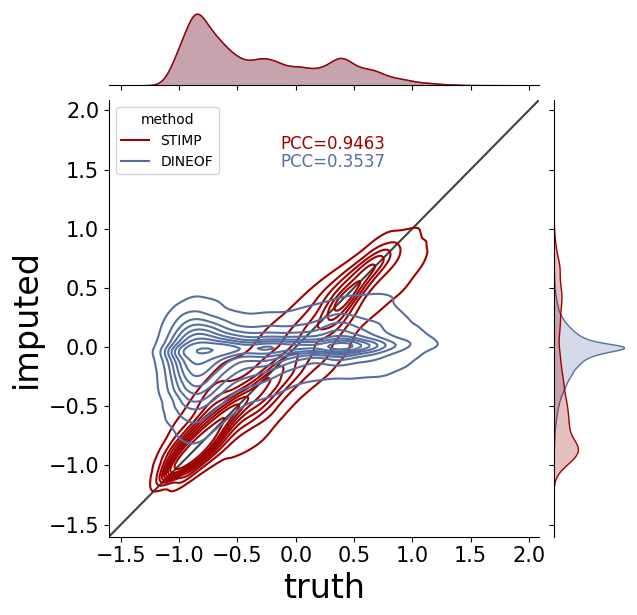

In [24]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.ylim(ypoints)
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:], imputed_our))
print(stat.pearsonr(truth[:], imputed_dineof))
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 3c: case study

In [25]:
from torch.utils.data import DataLoader
config.missing_ratio=0.1
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)

datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)
model = torch.load("./log/imputation/PRE/STIMP/best_0.1.pt")
model = model.to(device)

cond_mask = data_ob_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
truth = datas[0]
truth[~data_ob_masks[0].bool()]=np.nan

In [26]:
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(ob_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=config.in_len, c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

2025-05-11 14:59:31.080 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 167: 0.0024101396556943655, 9.974697604775429e-06


In [27]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(5, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(ob_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data_per = model.predict()
    imputed_data_per = rearrange(imputed_data_per, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data_per))

imputed_data_per = torch.cat(impute_data_list, dim=1).numpy()

2025-05-11 14:59:31.244 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 56: 0.0041714743711054325, 5.664769560098648e-06
2025-05-11 14:59:31.450 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 152: 0.002235795371234417, 9.55723226070404e-06
2025-05-11 14:59:31.649 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 153: 0.002534731524065137, 9.534414857625961e-06
2025-05-11 14:59:31.927 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 190: 0.00366205838508904, 9.81055200099945e-06
2025-05-11 14:59:32.212 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 208: 0.0030324955005198717, 9.872019290924072e-06
2025-05-11 14:59:32.555 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 259: 0.004456556402146816, 9.830575436353683e-06
2025-05-11 14:59:32.774 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error

In [28]:
imputed_dineof = imputed_data[0,:,0]
imputed_dineof_per = imputed_data_per[0,:,0]
imputed_stimp = torch.zeros(46,60,96)
imputed_stimp[:,is_sea.astype(bool)]=imputed_data_our[0,:,0]

observed = torch.zeros(46,60,96)
observed[:,is_sea.astype(bool)]=truth.cpu().squeeze()

In [29]:
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks
imputed_stimp = torch.where(ob_mask_image[0,:,0].cpu().bool(), observed, imputed_stimp)
imputed_dineof = torch.where(ob_mask_image[0,:,0].cpu().bool(), observed, torch.from_numpy(imputed_dineof))
imputed_dineof_per = torch.where(ob_mask_image[0,:,0].cpu().bool(), observed, torch.from_numpy(imputed_dineof_per))

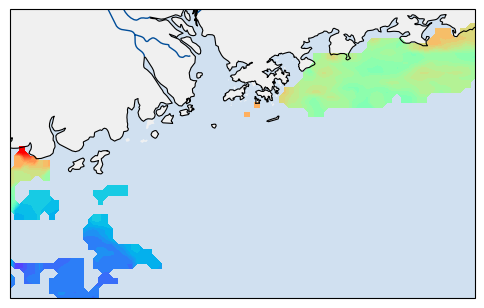

In [30]:
#oral observation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from copy import deepcopy

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

t=0
is_sea =np.load("./data/PRE/is_sea.npy")
lon = np.load("./data/PRE/lon.npy")
lati = np.load("./data/PRE/lati.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

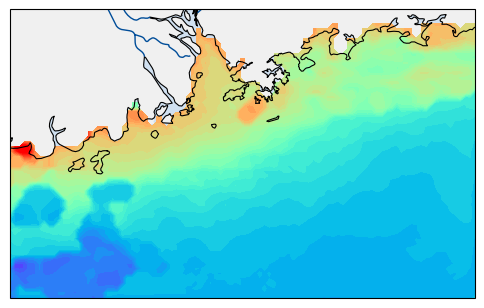

In [31]:
#STIMP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

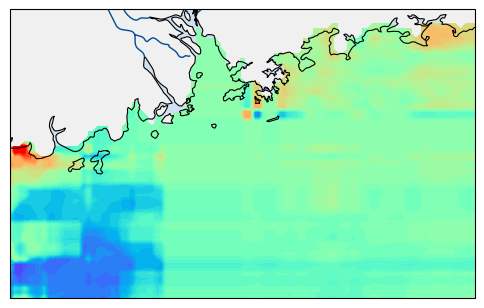

In [32]:
#DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

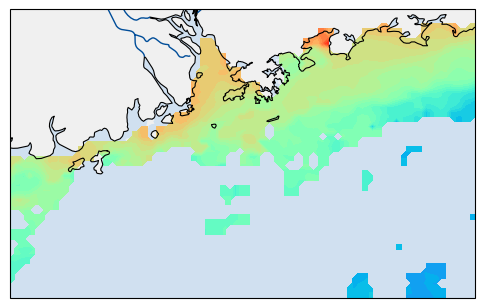

In [33]:
t=13

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

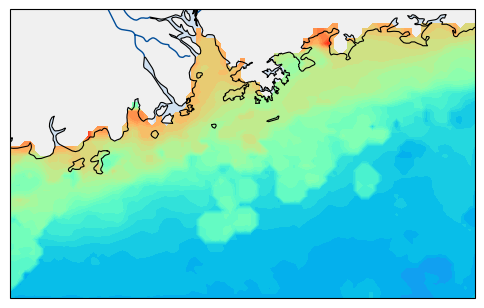

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

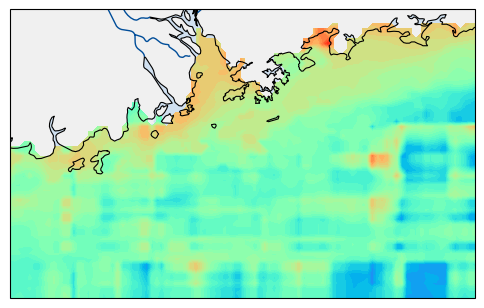

In [35]:
# DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

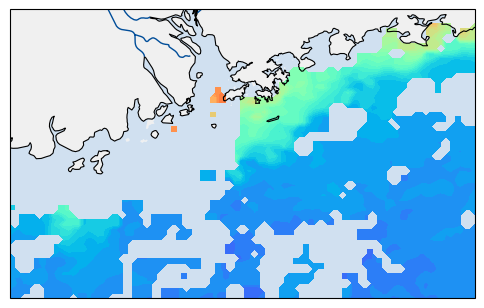

In [36]:
t=33

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

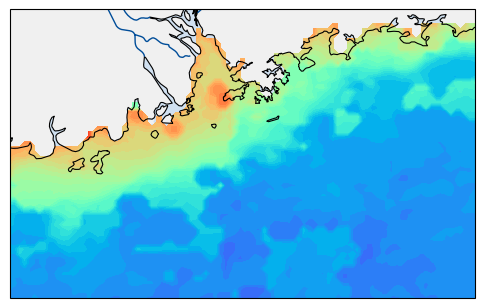

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

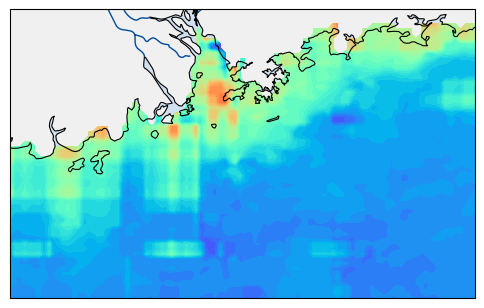

In [38]:
# DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

## Response Letter DINEOF(t=1) vs DINEOF(t=46)

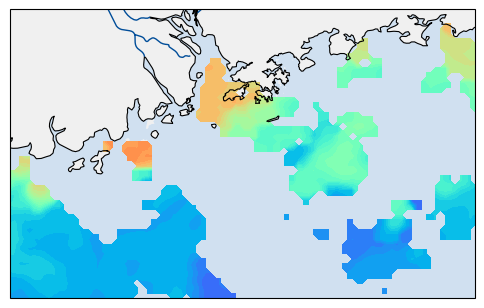

In [39]:
t=42

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

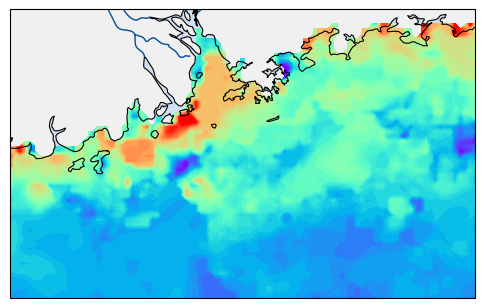

In [40]:
# DINEOF
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

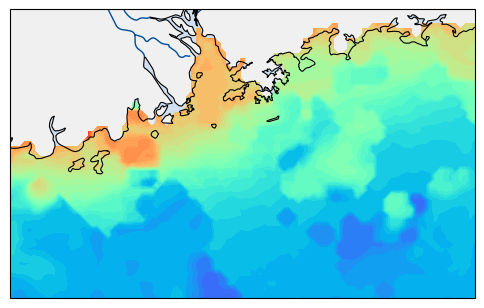

In [41]:
#STIMP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

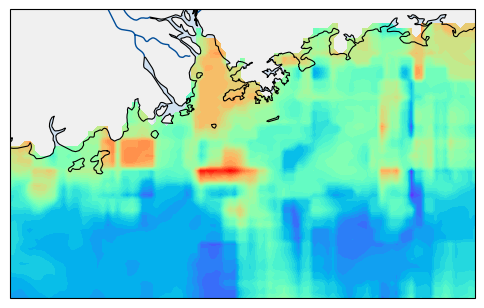

In [42]:
# DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

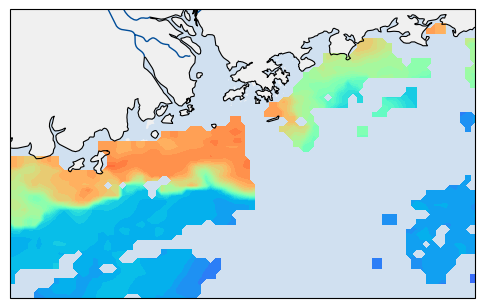

In [43]:
t=43

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

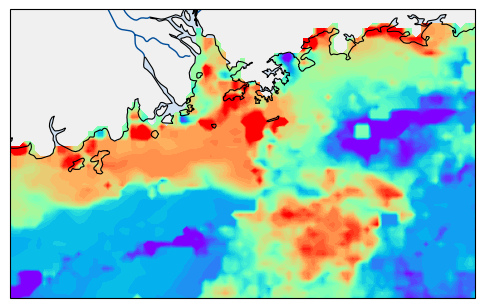

In [44]:
# DINEOF
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

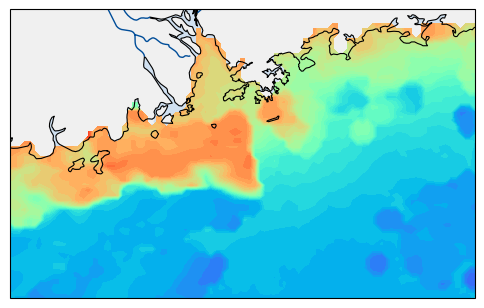

In [45]:
#STIMP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

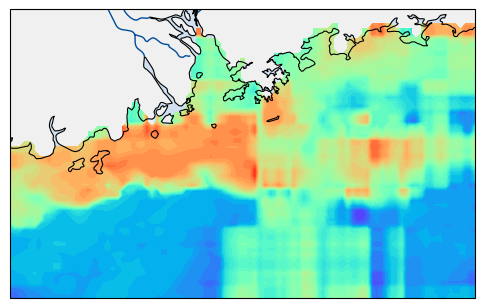

In [46]:
# DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

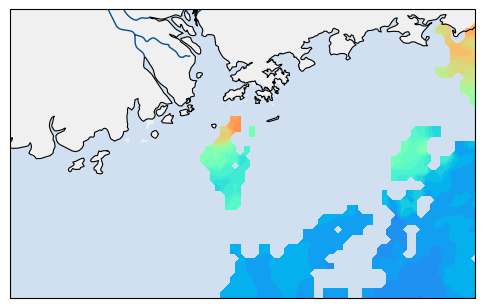

In [47]:
t=44

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})
lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())

tmp = deepcopy(observed[t].numpy())
tmp[~is_sea.astype(bool)]= np.nan

axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

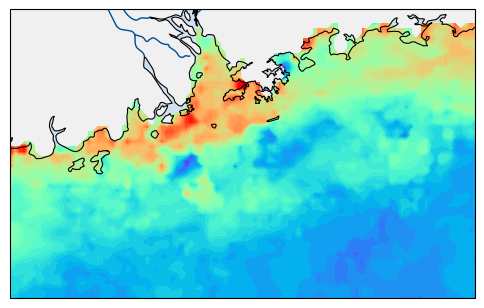

In [48]:
# DINEOF
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes.set_extent([lon1, lon2, lati1, lati2], crs=ccrs.PlateCarree())
tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

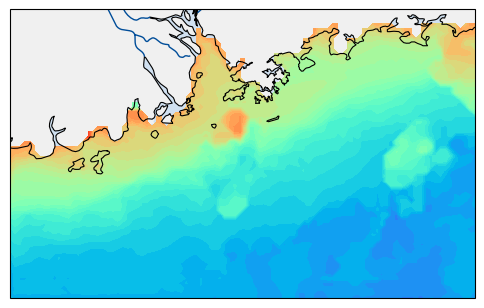

In [49]:
#STIMP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_stimp[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

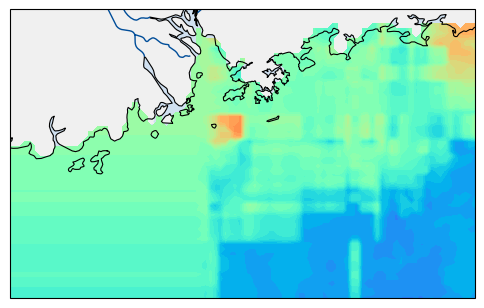

In [50]:
#DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())

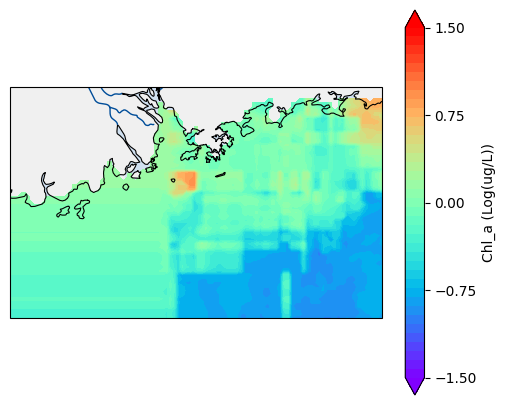

In [51]:
#DINEOF_per
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})

tmp = deepcopy(imputed_dineof_per[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp[~is_sea.astype(bool)]= np.nan

# 添加基础地理特征
axes.add_feature(cfeature.LAND, facecolor='#f0f0f0')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
axes.add_feature(cfeature.OCEAN, facecolor='#d0e0f0')
axes.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#d0e0f0')
axes.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#004d99')

contourf = axes.contourf(lon, lati, tmp, 
                        levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both',transform=ccrs.PlateCarree())
cbar = fig.colorbar(contourf, ax=axes, ticks=np.linspace(-1.5, 1.5, 5), orientation='vertical', shrink=1)
cbar.set_label('Chl_a (Log(ug/L))')